In [6]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import os
import zipfile
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
import random
plt.ion() 

In [2]:
#!wget http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-trainingSet.zip

In [3]:
#zip_ref = zipfile.ZipFile('sigComp2011-trainingSet.zip', 'r')
#zip_ref.extractall(pwd=b'I hereby accept the SigComp 2011 disclaimer.')
#zip_ref.close()

In [13]:
current_dir = os.path.dirname('F://sigComp2011-trainingSet/')

genuine_folder = os.path.join(current_dir, 'trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine')
forgeries_folder = os.path.join(current_dir, 'trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries')

In [14]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [15]:
genuine_data = []
genuine_label = []
for filename in os.listdir(genuine_folder):
    im = Image.open(os.path.join(genuine_folder, filename), 'r')       
    im = trim(im)                                                     #trimming images roughly till the borders
    
    imgnd = np.array(im)
    
    img = cv2.cvtColor(imgnd, cv2.COLOR_RGB2BGR)                      #converting PIL image to CV2 image
    h, w, d = img.shape                                               #getting dimesnions of image
    
    crop_img = img[30:h-30, 30:w-30]                                  #cropping 30+30 pixels extra to remove slant borders
    height, width, depth = crop_img.shape                             # getting gimesnions of cropped image
    
    img_padded = cv2.copyMakeBorder(crop_img,
                                    (350-(height-int(height/2))), (350-int(height/2)), (550-int(width/2)), (550-(width-int(width/2))),
                                    cv2.BORDER_CONSTANT, value = [255,255,255])
    crop_img_final = img_padded[200:600, 100:900]
    
    genuine_data.append(crop_img_final)
    genuine_label.append(filename)
    


In [16]:
#Forgeries Data

forgeries_data = []
forged_label = []
for filename in os.listdir(forgeries_folder):
    im = Image.open(os.path.join(forgeries_folder, filename), 'r')
    im = trim(im)                                                     #trimming images roughly till the borders
    
    imgnd = np.array(im)
    
    img = cv2.cvtColor(imgnd, cv2.COLOR_RGB2BGR)                      #converting PIL image to CV2 image
    h, w, d = img.shape                                               #getting dimesnions of image
    
    crop_img = img[30:h-30, 30:w-30]                                  #cropping 30+30 pixels extra to remove slant borders
    height, width, depth = crop_img.shape                             # getting gimesnions of cropped image
    
    img_padded = cv2.copyMakeBorder(crop_img,
                                    (350-(height-int(height/2))), (350-int(height/2)), (550-int(width/2)), (550-(width-int(width/2))),
                                    cv2.BORDER_CONSTANT, value = [255,255,255])
    crop_img_final = img_padded[200:600, 100:900]
    
    forgeries_data.append(crop_img_final)
    forged_label.append(filename)

In [17]:
#Resized images 800 x 1600 numpy arrays
genuine_signs = np.array(genuine_data)
forged_signs = np.array(forgeries_data)

In [18]:
#names of images
genuine_labels = np.array(genuine_label)
forged_labels = np.array(forged_label)

In [19]:
print(genuine_signs.shape)
print(forged_signs.shape)
print(genuine_labels.shape)
print(forged_labels.shape)

(235, 400, 800, 3)
(340, 400, 800, 3)
(235,)
(340,)


In [20]:
#Getting author labels

glabels = np.zeros((genuine_labels.shape[0]))
for i in range (genuine_labels.shape[0]):
    for j in range (10):
        if int(genuine_labels[i][1:3]) == (j+1):
            glabels[i] = int(genuine_labels[i][1:3])  #author 1 to 10 are genuine
            
flabels = np.zeros((forged_labels.shape[0]))
for i in range (forged_labels.shape[0]):
    for j in range (16):
        if int(forged_labels[i][2:4]) == (j+1):
            flabels[i] = int(forged_labels[i][2:4])  
            
flabels = flabels + 10  #author 11 to 26 are forged....with forged author index = flabel - 10

9.0


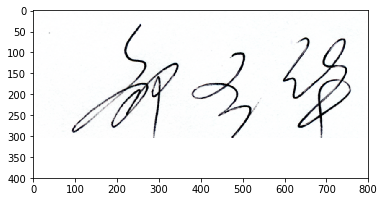

In [21]:
print(glabels[200])
imgplot = plt.imshow(genuine_signs[200])

10.0


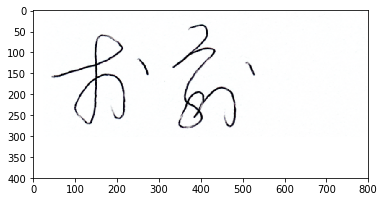

In [22]:
#Testing resized forged image
print(flabels[5])
imgplot = plt.imshow(forged_signs[5])

In [23]:
x_train = np.concatenate((genuine_signs, forged_signs))
y_train = np.concatenate((glabels, flabels))

In [24]:
print(x_train.shape)

(575, 400, 800, 3)


In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [16]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [25]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [18]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))